# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 2: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2022-11-24 16:11:21--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 142.250.128.95, 142.251.6.95, 108.177.112.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|142.250.128.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M   165MB/s    in 2.3s    

2022-11-24 16:11:24 (165 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [4]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 227; 
img_width = 227;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [5]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

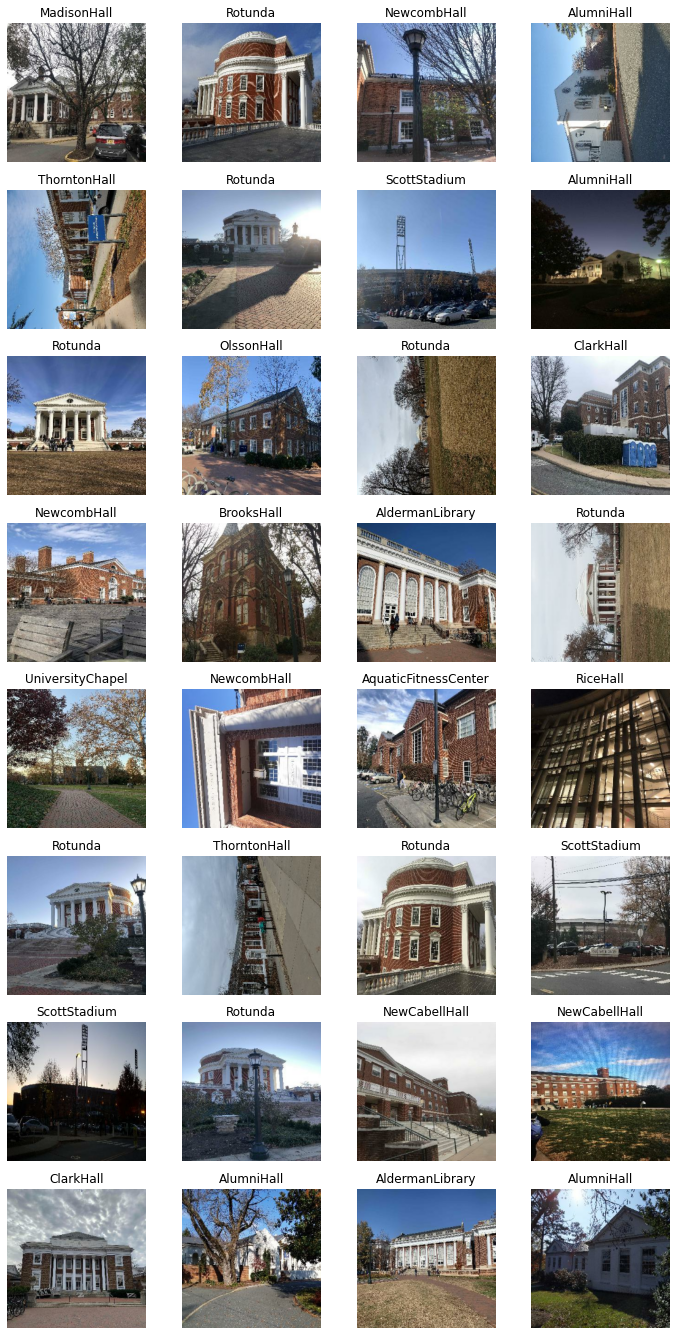

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# Step 3: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have? 
2.   Why do you decide on a certain number nodes per layer? 
3.   Which activation functions do you choose? 
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




In [7]:
# AlexNet: https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
# LeNet-5: https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342
keras.backend.clear_session()

myModel  = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),
                        activation='relu', input_shape=(227, 227, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1),
                        activation='relu', padding='same'),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),
                        activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),
                        activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(20, activation='softmax'),
])

myModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 384)       885120    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 384)      1

**How many layers does it have?<br>**
14 layers<br>

**Why do you decide on a certain number nodes per layer?<br>**
I conducted research using the sources above to determine the number of nodes.
<br>

**Which activation functions do you choose?<br>**
I chose Rectified Linear Unit (ReLU) for the hidden layers and softmax for the output layer.
<br>

**How many parameters does it has in total?<br>**
1,166,350,868 parameters in total, 1,166,349,140 trainable parameters

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [8]:
myEpochs = 20
myOptimizer = keras.optimizers.SGD(learning_rate=0.001)
myLoss = "sparse_categorical_crossentropy"
myMetrics = ["accuracy"]
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history = myModel.fit(train_ds, epochs=myEpochs, validation_data=validation_ds)

Epoch 1/20
358/358 [==============================] - 27s 46ms/step - loss: 2.9646 - accuracy: 0.2252 - val_loss: 2.0414 - val_accuracy: 0.4109
Epoch 2/20
358/358 [==============================] - 16s 44ms/step - loss: 1.9453 - accuracy: 0.4419 - val_loss: 1.6945 - val_accuracy: 0.4953
Epoch 3/20
358/358 [==============================] - 16s 44ms/step - loss: 1.4752 - accuracy: 0.5637 - val_loss: 1.4139 - val_accuracy: 0.5996
Epoch 4/20
358/358 [==============================] - 16s 44ms/step - loss: 1.1042 - accuracy: 0.6698 - val_loss: 1.4457 - val_accuracy: 0.5922
Epoch 5/20
358/358 [==============================] - 16s 44ms/step - loss: 0.8101 - accuracy: 0.7541 - val_loss: 1.2714 - val_accuracy: 0.6335
Epoch 6/20
358/358 [==============================] - 16s 44ms/step - loss: 0.5984 - accuracy: 0.8212 - val_loss: 1.0819 - val_accuracy: 0.6941
Epoch 7/20
358/358 [==============================] - 16s 44ms/step - loss: 0.4451 - accuracy: 0.8723 - val_loss: 1.0614 - val_accuracy:

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)? 
- Where did it makes mistake most? 
- Which classes can be improved?

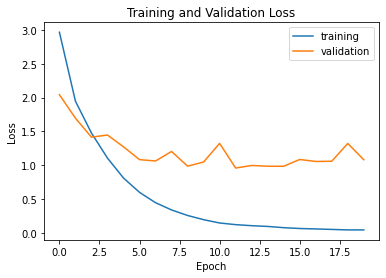

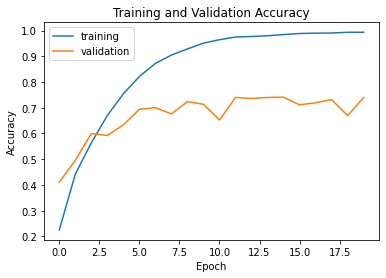

1/1 [==============================] - 0s 113ms/step
[[ 54   1   0   0   0   2   1   4   1   0   0   2   0   2   7   1   1   3]
 [  1 109   3   0   0   1   2   3   4   1   0   2   2   6   1   7   2   4]
 [  1   1  71   0   0   1   0   0   0   0   0   2   0   5   0   0   0   1]
 [  2   1   1  76   3   3   2   4   1   4   0   0   3   3   1   5   4   5]
 [  1   1   0   0  13   0   0   0   1   1   0   0   2   3   1   1   1   2]
 [  0   0   0   0   0  57   0   3   0   1   0   0   1  14   0   0   1   3]
 [  1   5   3   1   0   3 118   3   2   3   0   4   1  10   6   3   4   4]
 [  0   0   1   0   1   1   1  52   0   0   0   0   0   5   1   2   2   0]
 [  1   0   0   0   1   5   0   1 106   2   1   2   4  13   2   2   2   2]
 [  0   3   2   9   0   6   2   1   2  72   1   2   2  13   3   1   6   5]
 [  0   3   1   5   2   4   2   7   5   2  75   2   8   9   3   4   7   2]
 [  3   3   5   0   1   1   3   3   1   1   1 119   0  13  10   0   1   2]
 [  1   2   2   1   0   2   2   4   3   3   0  

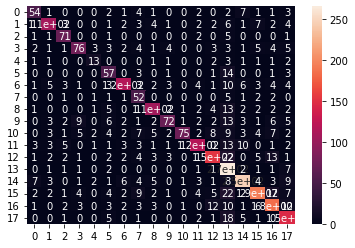

In [9]:
# source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. plot of training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

# 2. plot of training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# confusion matrix
y_predict = []
y_true = []
for images, labels in validation_ds:
  for i in labels:
    y_true.append(i)
  for predict in myModel.predict(images):
    y_predict.append(predict.argmax())

cm = confusion_matrix(y_true, y_predict)
print(cm)

sns.heatmap(cm, annot=True)


**How well do you think your architecture is doing (overall accuracy)?**<br>
Overall, the AlexNet model performed well with a final training accuracy of 0.9933 and a final validation accuracy of 0.7396. 
<br>**Where did it makes mistake most?**<br>
It would appear that the AlexNet model performed made the most mistakes classifying Scott Stadium into other classes like Rice Hall (22 times) and Clark Hall (9 times). Other poor classifying behavior is seen with the University Chapel and Thornton Hall.
<br>**Which classes can be improved?**<br>
The AlexNet model can improve on classifying Scott Stadium, the University Chapel, and Thornton Hall. 

# Step 4: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [ ]:
# source: https://cv-tricks.com/keras/understand-implement-resnets/
# source: https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8
from keras.applications.resnet import ResNet152
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

keras.backend.clear_session()

resnet_model = ResNet152(weights='imagenet', include_top=False)
images_resized = tf.image.resize(images, [224, 224])
inputs = preprocess_input(images_resized * 256)

avg = GlobalAveragePooling2D()(resnet_model.output)
outputs = Dense(20, activation='softmax')(avg)

resnet_final_model = Model(inputs=resnet_model.input, outputs=outputs)

for index, layer in enumerate(resnet_model.layers):
  print(index, layer.name)
resnet_final_model.summary()

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

**How many layers does it have?<br>**
514 layers<br>

**Why do you decide on a certain number nodes per layer?<br>**
I decided on certain number of nodes (like 20 for the output layer) based on the AlexNet performance and research done on the ResNet152 model.
<br>
**Which activation functions do you choose?<br>**
I chose softmax for the output layer.
<br>
**How many parameters does it has in total?<br>**
58,411,924 parameters in total, 58,260,500 trainable parameters.

Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [ ]:
# 1. phase 1: freeze the pre-train weights and only train the top layer

for layer in resnet_model.layers:
  layer.trainable = False

myEpochs = 20
myOptimizer = keras.optimizers.SGD(learning_rate=0.1)
myLoss = "sparse_categorical_crossentropy"
myMetrics = ["accuracy"]
resnet_final_model.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
resnet_history = resnet_final_model.fit(train_ds, epochs=myEpochs, validation_data=validation_ds)

Epoch 1/20
358/358 [==============================] - 127s 332ms/step - loss: 4.9523 - accuracy: 0.5506 - val_loss: 14.4788 - val_accuracy: 0.2100
Epoch 2/20
358/358 [==============================] - 117s 326ms/step - loss: 1.5036 - accuracy: 0.7577 - val_loss: 10.9462 - val_accuracy: 0.2128
Epoch 3/20
358/358 [==============================] - 117s 326ms/step - loss: 1.0697 - accuracy: 0.8034 - val_loss: 11.7517 - val_accuracy: 0.2835
Epoch 4/20
358/358 [==============================] - 117s 325ms/step - loss: 0.8408 - accuracy: 0.8404 - val_loss: 11.0372 - val_accuracy: 0.2335
Epoch 5/20
358/358 [==============================] - 117s 325ms/step - loss: 0.6539 - accuracy: 0.8660 - val_loss: 2.7152 - val_accuracy: 0.5947
Epoch 6/20
358/358 [==============================] - 117s 325ms/step - loss: 0.5198 - accuracy: 0.8828 - val_loss: 18.1866 - val_accuracy: 0.1414
Epoch 7/20
358/358 [==============================] - 117s 326ms/step - loss: 0.5807 - accuracy: 0.8861 - val_loss: 3.3

In [ ]:
# 2. phase 2: train the entire network with much smaller learning rate

for layer in resnet_model.layers:
  layer.trainable = True

myEpochs = 20
myOptimizer = keras.optimizers.SGD(learning_rate=0.01)
myLoss = "sparse_categorical_crossentropy"
myMetrics = ["accuracy"]
resnet_final_model.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
resnet_history = resnet_final_model.fit(train_ds, epochs=myEpochs, validation_data=validation_ds)

Epoch 1/20
358/358 [==============================] - 344s 918ms/step - loss: 0.4114 - accuracy: 0.9018 - val_loss: 0.5129 - val_accuracy: 0.9016
Epoch 2/20
358/358 [==============================] - 325s 908ms/step - loss: 0.0426 - accuracy: 0.9878 - val_loss: 0.6600 - val_accuracy: 0.8862
Epoch 3/20
358/358 [==============================] - 326s 909ms/step - loss: 0.0116 - accuracy: 0.9976 - val_loss: 0.3313 - val_accuracy: 0.9391
Epoch 4/20
358/358 [==============================] - 325s 909ms/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.3145 - val_accuracy: 0.9520
Epoch 5/20
358/358 [==============================] - 326s 909ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 2.2698 - val_accuracy: 0.7966
Epoch 6/20
358/358 [==============================] - 323s 902ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.3112 - val_accuracy: 0.9520
Epoch 7/20
358/358 [==============================] - 325s 907ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.3038 -

Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall? 
- In which class it improve the accuracy from the above model? 
- Which class still has low performance? 

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

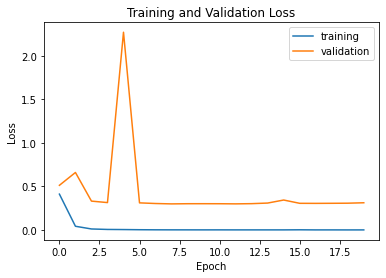

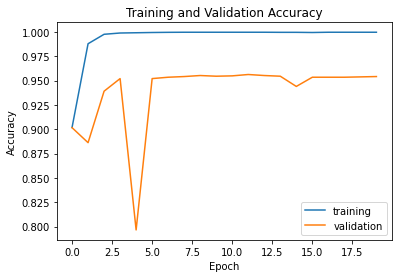

1/1 [==============================] - 3s 3s/step
[[ 75   0   0   0   0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0 141   0   0   1   0   2   1   0   0   1   0   1   0   1   0   0   0]
 [  0   0  80   0   0   0   0   0   1   0   0   0   0   0   0   0   1   0]
 [  0   0   0 111   0   0   0   1   0   0   0   0   1   0   0   2   3   0]
 [  0   0   0   0  22   0   0   0   0   0   2   0   0   0   1   1   0   1]
 [  0   0   0   0   0  76   0   0   0   3   0   0   0   0   1   0   0   0]
 [  1   0   1   1   0   0 159   0   1   4   0   0   0   1   1   0   2   0]
 [  0   0   1   0   0   0   0  62   0   0   0   0   0   0   2   1   0   0]
 [  0   1   0   0   0   0   0   0 142   0   0   0   1   0   0   0   0   0]
 [  0   0   1   2   0   0   0   0   0 121   0   2   0   1   0   2   0   1]
 [  0   0   0   0   0   0   0   0   0   5 135   0   0   0   1   0   0   0]
 [  1   0   0   1   0   0   1   0   2   3   0 156   0   0   2   0   0   1]
 [  0   0   0   1   0   0   0   1   1   1   0   0 

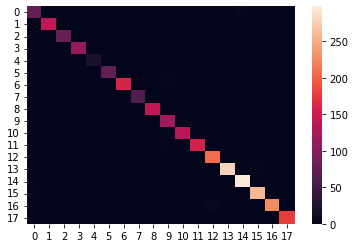

In [ ]:
# source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. plot of training and validation loss
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

# 2. plot of training and validation accuracy
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# confusion matrix
y_predict = []
y_true = []
for images, labels in validation_ds:
  for i in labels:
    y_true.append(i)
  for predict in resnet_final_model.predict(images):
    y_predict.append(predict.argmax())

cm = confusion_matrix(y_true, y_predict)
print(cm)

sns.heatmap(cm)

**Did this pre-trained network do better overall?**<br>
Yes, overall, the pre-trained network achieved a higher training (0.9997) and validation accuracy score (0.9541). Additionally, the values in the confusion matrix were lower compared to my network's confusion matrix overall.
<br>

**In which class did it improve the accuracy from the above model?** <br>
Every class saw an increase in accuracy as seen by the confusion matrix's low numbers in the non-diagonal positions. Most importantly, there was an increase in accuracy in classifying Thornton Hall, the University Chapel, and Scott Stadium.
<br>

**Which class still has low performance?** <br>
Scott Stadium still has the highest occurances of incorrect classifying (Academic Village, 4 times; Rotunda, 2 times; Rice Hall, 2 times; etc).
<br>

# Step 5: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!

In this assignment, I implemented my own CNN and a pre-trained model. For my implementation, I used the AlexNet model. For the pre-trained model, I used the ResNet152 model. I have better performance with the ResNet152 model. The AlexNet model requires 227x227 images and contains (usually) 8 lauers with convolutional layers, batch normalization layers, max pooling layers, and additional layers. In comparison, ResNet152 utilizes more layers (152 layers) and uses shortcut connects to input a previous layer's output to the next layer without needing modification. Overall, I found this assignment fun because I was able to dive deeper into the different CNN architectures and experiment. I think I learned how the learning rate impacts the CNN architecture the most because that was the variable I adjusted the most.